In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.gridspec as gridspec
from matplotlib.pyplot import (figure, title, boxplot, xticks, subplot, hist,
                               xlabel, ylim, yticks, show, savefig)
import numpy as np

In [13]:
df = pd.read_csv('hour.csv')

In [14]:
# PREPROCESSING

# Removing useless attributes
df = df.drop('dteday', axis=1)
df = df.drop('instant', axis=1)
df = df.drop('yr', axis=1)

# Applying sqrt to "cnt" (to make it a continuous variable)
df['cnt'] = np.sqrt(df['cnt'])

# Removing deprecated attributes after the sqrt transformation (cnt = casual + registered)
df = df.drop('casual', axis=1)
df = df.drop('registered', axis=1)
df = df.drop('atemp', axis=1)

df.head()

,season,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,1,1,0,0,6,0,1,0.24,0.81,0.0,4.000000
1,1,1,1,0,6,0,1,0.22,0.80,0.0,6.324555
2,1,1,2,0,6,0,1,0.22,0.80,0.0,5.656854
3,1,1,3,0,6,0,1,0.24,0.75,0.0,3.605551
4,1,1,4,0,6,0,1,0.24,0.75,0.0,1.000000


In [15]:
from sklearn.preprocessing import StandardScaler

X_full = df.values
scaler = StandardScaler()
X_full_scaled = scaler.fit_transform(X_full)
df = pd.DataFrame(X_full_scaled, columns=df.columns)

X = df.drop(columns=['cnt']).values
attributeNames = df.columns.drop(['cnt']).tolist()
N, M = X.shape
y = df['cnt'].values

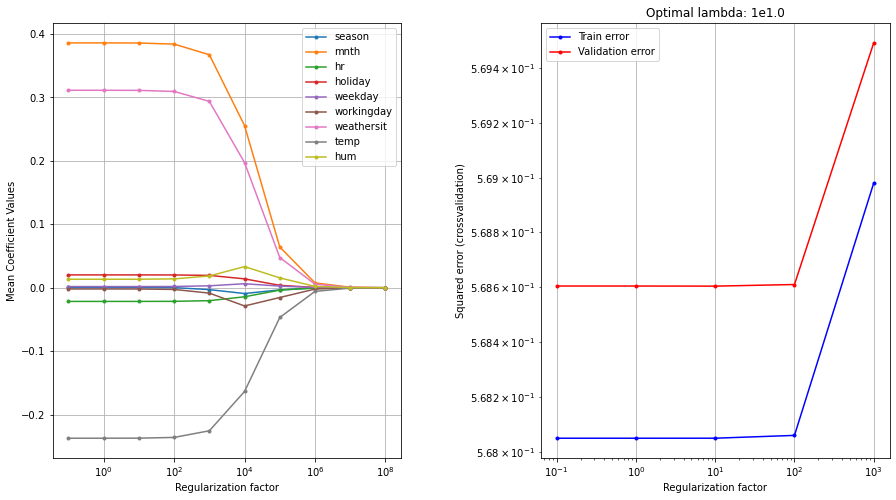

In [16]:
from matplotlib.pylab import (figure, semilogx, loglog, xlabel, ylabel, legend, 
                           title, subplot, show, grid)
import numpy as np
from scipy.io import loadmat
import sklearn.linear_model as lm
from sklearn import model_selection
from toolbox_02450 import rlr_validate


## Crossvalidation
# Create crossvalidation partition for evaluation
K = 10
CV = model_selection.KFold(K, shuffle=True)

# Values of lambda
lambdas = np.power(10.,range(-1,9))

# get optimal lambda and errors
opt_val_err, opt_lambda, mean_w_vs_lambda, train_err_vs_lambda, test_err_vs_lambda = rlr_validate(X, y, lambdas, K)

# Display the results for the last cross-validation fold
figure(figsize=(15,8))
subplot(1,2,1)
semilogx(lambdas,mean_w_vs_lambda.T[:,1:],'.-') # Don't plot the bias term
xlabel('Regularization factor')
ylabel('Mean Coefficient Values')
grid()
# You can choose to display the legend, but it's omitted for a cleaner 
# plot, since there are many attributes
legend(attributeNames, loc='best')

plt.subplots_adjust(wspace=0.4, hspace=1.4)  # You can adjust the values for more or less space

subplot(1,2,2)
title('Optimal lambda: 1e{0}'.format(np.log10(opt_lambda)))
# plotting in range -1,4 for optimal visualization
loglog(lambdas[:5],train_err_vs_lambda.T[:5],'b.-',lambdas[:5],test_err_vs_lambda.T[:5],'r.-')
xlabel('Regularization factor')
ylabel('Squared error (crossvalidation)')
legend(['Train error','Validation error'])
grid()
savefig('res/plots/lambda.png')

# Two-layer cross-validation

In [9]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.tree import DecisionTreeRegressor  # Import an example model

# Assuming you have your data (X, y) ready.

# Number of splits for both outer and inner cross-validation
K1 = 10
K2 = 10

# Initialize variables to store the average performance for each model
baseline_mse = 0.0
model_mse = 0.0

# Outer cross-validation loop
kf_outer = KFold(n_splits=K1, shuffle=True, random_state=42)
for train_index, test_index in kf_outer.split(X):
    X_train_outer, X_test_outer = X[train_index], X[test_index]
    y_train_outer, y_test_outer = y[train_index], y[test_index]
    
    # Baseline model (linear regression with no features)
    baseline_model = LinearRegression()
    baseline_model.fit(X_train_outer, y_train_outer)
    y_pred_baseline = baseline_model.predict(X_test_outer)
    baseline_mse += mean_squared_error(y_test_outer, y_pred_baseline)

    # Inner cross-validation loop for model selection (e.g., hyperparameter tuning)
    kf_inner = KFold(n_splits=K2, shuffle=True, random_state=42)
    best_inner_model = None
    best_inner_mse = float('inf')
    for train_index_inner, test_index_inner in kf_inner.split(X_train_outer):
        X_train_inner, X_val_inner = X_train_outer[train_index_inner], X_train_outer[test_index_inner]
        y_train_inner, y_val_inner = y_train_outer[train_index_inner], y_train_outer[test_index_inner]
        
        # Create and train your model on the training data
        # For example, you can use a decision tree model
        model = DecisionTreeRegressor()  # Use DecisionTreeRegressor as an example
        model.fit(X_train_inner, y_train_inner)
        
        # Make predictions on the validation set
        y_pred_val = model.predict(X_val_inner)
        
        # Calculate the mean squared error for model evaluation
        mse_val = mean_squared_error(y_val_inner, y_pred_val)
        
        # Update the best model if the current one is better
        if mse_val < best_inner_mse:
            best_inner_mse = mse_val
            best_inner_model = model
    
    # Use the best model from the inner loop to make predictions on the test data
    y_pred_model = best_inner_model.predict(X_test_outer)
    model_mse += mean_squared_error(y_test_outer, y_pred_model)

# Calculate the average MSE for the baseline model and the selected model
baseline_mse /= K1
model_mse /= K1

print("Average Baseline Model MSE:", baseline_mse)
print("Average Selected Model MSE:", model_mse)

Average Baseline Model MSE: 25.63551667586218
Average Selected Model MSE: 7.753584836053713


In [ ]:
# exercise 8.2.2
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
from sklearn import model_selection
from toolbox_02450 import train_neural_net, draw_neural_net, visualize_decision_boundary
import torch
plt.rcParams.update({'font.size': 12})


# K-fold CrossValidation (4 folds here to speed up this example)
K = 2
CV = model_selection.KFold(K,shuffle=True)

# Define the model structure
n_hidden_units = 1 # number of hidden units in the signle hidden layer
# The lambda-syntax defines an anonymous function, which is used here to 
# make it easy to make new networks within each cross validation fold
model = lambda: torch.nn.Sequential(
                    torch.nn.Linear(M, n_hidden_units), #M features to H hiden units
                    # 1st transfer function, either Tanh or ReLU:
                    torch.nn.Tanh(),                            #torch.nn.ReLU(),
                    torch.nn.Linear(n_hidden_units, 1), # H hidden units to 1 output neuron
                    torch.nn.Sigmoid() # final tranfer function
                    )
# Since we're training a neural network for binary classification, we use a 
# binary cross entropy loss (see the help(train_neural_net) for more on
# the loss_fn input to the function)
loss_fn = torch.nn.BCELoss()
# Train for a maximum of 10000 steps, or until convergence (see help for the 
# function train_neural_net() for more on the tolerance/convergence))
max_iter = 10000
print('Training model of type:\n{}\n'.format(str(model())))

# Do cross-validation:
errors = [] # make a list for storing generalizaition error in each loop
# Loop over each cross-validation split. The CV.split-method returns the 
# indices to be used for training and testing in each split, and calling 
# the enumerate-method with this simply returns this indices along with 
# a counter k:
for k, (train_index, test_index) in enumerate(CV.split(X,y)): 
    print('\nCrossvalidation fold: {0}/{1}'.format(k+1,K))    
    
    # Extract training and test set for current CV fold, 
    # and convert them to PyTorch tensors
    X_train = torch.Tensor(X[train_index,:] )
    y_train = torch.Tensor(y[train_index] )
    X_test = torch.Tensor(X[test_index,:] )
    y_test = torch.Tensor(y[test_index] )
    
    # Go to the file 'toolbox_02450.py' in the Tools sub-folder of the toolbox
    # and see how the network is trained (search for 'def train_neural_net',
    # which is the place the function below is defined)
    net, final_loss, learning_curve = train_neural_net(model,
                                                       loss_fn,
                                                       X=X_train,
                                                       y=y_train,
                                                       n_replicates=3,
                                                       max_iter=max_iter)
    
    print('\n\tBest loss: {}\n'.format(final_loss))
    
    # Determine estimated class labels for test set
    y_sigmoid = net(X_test) # activation of final note, i.e. prediction of network
    y_test_est = (y_sigmoid > .5).type(dtype=torch.uint8) # threshold output of sigmoidal function
    y_test = y_test.type(dtype=torch.uint8)
    # Determine errors and error rate
    e = (y_test_est != y_test)
    error_rate = (sum(e).type(torch.float)/len(y_test)).data.numpy()
    errors.append(error_rate) # store error rate for current CV fold 
    predict = lambda x: net(torch.tensor(x, dtype=torch.float)).data.numpy()
    
print('\nGeneralization error/average error rate: {0}%'.format(round(100*np.mean(errors),4)))
